In [1]:
import sys, os
import pandas as pd
import numpy as np
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.insert(1, '../scripts')
root = os.getcwd()


from TwintDataMiner import TwintDataMiner
from PandasDataCleaner import PandasDataCleaner
from TextBlobSentiment import TextBlobSentiment
from Visualisation import Visualisation
from GMM import GMM


In [2]:
tweetsFile = "../data/final_location_tweets.csv"
tdm = TwintDataMiner()
attributes = ["id", "tweet", "place", "date"]
df = tdm.getPandasDataFrame(attributes, tweetsFile)
df.shape
df.head

<bound method NDFrame.head of                         id                                              tweet  \
0                       id                                              tweet   
1      1237392766671269900  Coronavirus outbreak and our precautions #posh...   
2      1237392766633512961  Estoy hablando con mi amigi sobre el #coronavi...   
3      1237392763848556549  How do you feel about #Coachella and #Stagecoa...   
4      1237392763508809730  o melhor remédio para o corona vírus é o corot...   
...                    ...                                                ...   
58335  1237166326449344513  The latest on the #Coronavirus in #SouthCaroli...   
58336  1237166322150256641  if you ever used the restrooms at 216,\nyou’re...   
58337  1237166316496322561  El primer enfermo de coronavirus apareció hace...   
58338  1237166283449393153  Además del Coronavirus siguen los infartos, lo...   
58339  1237166282543251456  #Trumpdemic trends nationwide as people vent a...  

In [3]:
df.drop_duplicates(subset='id')
df.shape

(58340, 4)

In [4]:
pdc = PandasDataCleaner()
def cleandf(df):
    df  = pdc.detectLanguage(df, 'tweet', 'lang')
    df = pdc.cleanTweets(df, 'tweet')
    #only want english language tweets
    df = df.loc[df['lang'] == 'en']
    #reset index because of deleted tweets
    df = df.reset_index(drop=True)
    return df

In [5]:
df = cleandf(df)

Detecting language: 58339/58340

In [6]:
saveddf = df.copy()

In [346]:
df = saveddf.copy()
df.shape

(33509, 5)

In [50]:
#tweets come with specific locations, generalise this to countries
df = pdc.addGeneralLocation(df)

In [51]:
countDict = df.groupby('genplace').count()['id'].to_dict()
print(sorted( ((v,k) for k,v in countDict.items()), reverse=True))

[(3335, 'CA'), (3061, 'USA'), (1889, 'TX'), (1831, 'England'), (1669, 'NY'), (1316, 'FL'), (919, 'India'), (686, 'OH'), (652, 'IL'), (634, 'London'), (598, 'PA'), (527, 'MA'), (498, 'Ontario'), (492, 'NJ'), (470, 'GA'), (443, 'TN'), (433, 'AZ'), (429, 'Ireland'), (412, 'NC'), (386, 'MD'), (380, 'DC'), (379, 'VA'), (375, 'Nigeria'), (357, 'WA'), (356, 'MI'), (340, 'South Africa'), (331, 'LA'), (304, 'IN'), (295, 'Scotland'), (272, 'NV'), (260, 'CO'), (253, 'MO'), (215, 'AL'), (208, 'Victoria'), (196, 'Spain'), (195, 'OK'), (187, 'UT'), (180, 'MN'), (171, 'New South Wales'), (167, 'CT'), (165, 'SC'), (164, 'OR'), (161, 'WI'), (160, 'KY'), (150, 'Pakistan'), (146, 'Alberta'), (145, 'Ghana'), (143, 'KS'), (129, 'Brazil'), (123, 'IA'), (120, 'Northern Ireland'), (119, 'Wales'), (117, 'France'), (116, 'NE'), (114, 'Kenya'), (108, 'National Capital Region'), (108, 'Argentina'), (102, 'British Columbia'), (101, 'Germany'), (100, 'AR'), (98, 'Québec'), (94, 'NM'), (94, 'MS'), (80, 'Nederland'),

In [52]:
#these are countries with enough tweets, also removes duplicates e.g. brazil and brasil
countries_to_model = ['USA', 'England', 'India', 'Ireland', 'Nigeria', 'South Africa', 'Scotland', 'Spain', 'Pakistan', 'Ghana', 'Brazil', 'Northern Ireland', 'Wales', 'France', 'Kenya', 'Argentina', 'Germany', 'Nederland', 'United Arab Emirates', 'Sri Lanka', 'Uganda', 'Indonesia', 'Türkiye', 'België', "People's Republic of China", 'Israel', 'Jamaica', 'Chile']

In [106]:
final_bow =['PPE',
 'afraid',
 'aggravation',
 'air',
 'alarmed',
 'alarming',
 'ante la crisis',
 'anxiety',
 'anxious',
 'apprehensive',
 'atmosphere',
 'brutal',
 'chaos',
 'chaotic',
 'charity',
 'clean air',
 'clean water',
 'comfort',
 'coronavirus fear',
 'crisis',
 'danger',
 'dangerous',
 'dead',
 'death',
 'disaster',
 'disastrous',
 'distress',
 'distressed',
 "don't panic",
 'donations',
 'earth',
 'encourage',
 'encouraging',
 'environment',
 'evil',
 'exaggerate',
 'exaggerating',
 'exaggeration',
 'faint',
 'fantastic',
 'fearful',
 'fearschaos',
 'fighter',
 'fitness',
 'flabbergast',
 'flabbergasted',
 'flatten',
 'food wastage',
 'freaked',
 'free',
 'fright',
 'frightened',
 'genocide',
 'gloves',
 'government funds',
 'gratitude',
 'grief',
 'grievance',
 'gruesome',
 'happy',
 'harm',
 'healing',
 'health issue',
 'heartbreaking',
 'hell',
 'helpless',
 'honor',
 'hope',
 'horrendous',
 'horrific',
 'horrify',
 'horrifying',
 'hospital',
 'humanity',
 'impovement',
 'improving',
 'kill',
 'killed',
 'killingthreat',
 'kills',
 'life-threatening',
 'masks',
 'meditation',
 'mild',
 'murder',
 'negative',
 'nervous',
 'not panic',
 'not serious',
 'nurses',
 'optimism',
 'optimistic',
 'overcome',
 'overreact',
 'overreacted',
 'overreacting',
 'ozone',
 'panic',
 'panick',
 'panicked',
 'panicking',
 'panicky',
 'paranoid',
 'pasta',
 'phobia',
 'positive',
 'problem',
 'progress',
 'promise',
 'promosing',
 'protect',
 'proud',
 'quality',
 'ran out',
 'rattle',
 'rattled',
 'recover',
 'recovery',
 'relief',
 'respect',
 'rice',
 'risk',
 'sad',
 'sadness',
 'scared',
 'scarefear',
 'scarier',
 'scariest',
 'scarily',
 'shock',
 'shocked',
 'shocking',
 'shockingly',
 'spanish flu',
 'strength',
 'strong',
 'stronger',
 'successfully',
 'support',
 'surreal',
 'terrible',
 'terror',
 'tests',
 'thank you',
 'thanks',
 'threatening',
 'together',
 'toilet paper',
 'tragic',
 'travel alert',
 'trust',
 'unbearable',
 'unhygienic',
 'unnerve',
 'unnerved',
 'unnerving',
 'unserious',
 'upset',
 'upseting',
 'upsets',
 'upsettingly',
 'vaccine',
 'warned'
 'warning',
 'wonderful',
 'worried',
 'worryingly',
 'worry',]

In [107]:
df = df.loc[df['genplace'].isin(countries_to_model)]
df = df.reset_index(drop=True)

In [108]:
df.head

<bound method NDFrame.head of                        id                                              tweet  \
0     1237392757691265028  Well, I give them some credit. They acknowledg...   
1     1237392715978911744  i am not cancelling nothing because of Coronav...   
2     1237392659850780672  @ImtiazMadmood we knew corona virus back in 60...   
3     1237392429424115712  Every one chasing #coronavirus  we people chas...   
4     1237392328442052608  10/3/2020 #Taaienberg #RVV20 ?#coronavirus  pi...   
...                   ...                                                ...   
9150  1237166699457261569  @SkyNews just heard the most irresponsible thi...   
9151  1237166563226275848  Made the mistake of listening to @BBCTheArcher...   
9152  1237166473367498752  White kid don't think he can get the coronavir...   
9153  1237166439053828096  SO TIRED of hearing about the coronavirus. You...   
9154  1237166326449344513  The latest on the #Coronavirus in #SouthCaroli...   

         

In [335]:
#used to sort silly skew of low tweet count data
def maxi(x, amax):
    if(x > 0.005):
        ratio = x / amax
        x = 0.005 * ratio
    return x
country_bows = dict()
gmm = GMM()
def returncountry(place, country):
    if(country in place):
        return True
    return False
for country in countries_to_model:
    country_bows[country] = []
    #make dataframe of tweets from a certain country
    countrydf = df[df['genplace'].apply(lambda x: returncountry(x, country))].copy()
    splitindex = int(countrydf.shape[0] / 5)
    #want to model countries data as 5 different groups
    for i in range(5):
        #create dataframe of tweets in group
        tempdf = countrydf[i*splitindex:(i+1)*splitindex].copy()
        tempdf.sort_values("id", inplace=True)
        
        
        #drop any duplicate tweets
        tempdf.drop_duplicates(subset=["tweet"],inplace=True) 
        tempdf = tempdf.reset_index(drop=True)
    
        bow = gmm.generateBagOfWords(tempdf, 'tweet', vocab=final_bow)
        country_tweet_count = tempdf.shape[0]
        #get bag of word for whole group
        panicRow = np.sum(bow, axis=0)
        #make bag of words proportional
        panicRow = np.true_divide(panicRow, country_tweet_count)
        amax = np.amax(panicRow)
        #apply maxi function to each data item
        panicRow = np.array(list(map(lambda x: maxi(x, amax), panicRow)))
        country_bows[country] = country_bows[country] + [panicRow]


    




[0.         0.00164745 0.         0.002      0.         0.
 0.         0.00329489 0.         0.         0.         0.
 0.00164745 0.         0.         0.         0.         0.
 0.         0.004      0.         0.00164745 0.00329489 0.002
 0.         0.         0.         0.         0.         0.
 0.00494234 0.         0.00164745 0.         0.00329489 0.
 0.00164745 0.         0.         0.00329489 0.         0.
 0.         0.00329489 0.         0.         0.         0.
 0.         0.0025     0.         0.         0.         0.00329489
 0.         0.         0.         0.         0.         0.00494234
 0.         0.         0.         0.         0.002      0.
 0.         0.0045     0.         0.00164745 0.         0.
 0.00494234 0.00494234 0.         0.         0.002      0.00494234
 0.         0.00494234 0.         0.00164745 0.         0.
 0.         0.00164745 0.00494234 0.         0.         0.
 0.         0.         0.         0.         0.         0.00164745
 0.         0.005    

In [336]:
from sklearn.feature_extraction.text import CountVectorizer
#keep track of which row in matrix belongs to which country
country_index_dict = dict()

bowMatrix = np.empty((1, len(final_bow)), int)

index_count = 0
for country in countries_to_model:
    country_index_dict[country] = []
    if(country in country_bows):
        for i in range(5):
            #add to matrix each bow
            bowMatrix = np.append(bowMatrix, np.reshape(country_bows[country][i], (1, len(final_bow))), axis=0)
            country_index_dict[country] = country_index_dict[country] + [index_count]
            index_count += 1
        
#remove initalisation row
bowMatrix = np.delete(bowMatrix, (0), axis=0)

#panic words
controltweet1 = ['death disaster scared unbearable upset worry terror terrible sad scarier risk problem negative panic panicked helpless harm grief fright fearful distress distressed crisis chaos afraid']
#non panic words
controltweet2 = ['recovery optimistic humanity comfort encourage wonderful trust charity clean encourage encouraging fantastic gratitude healing hope humanity improvement improving optimism positive recover strength support successfully']
count = CountVectorizer(vocabulary=final_bow)
bag_of_words_bad = count.fit_transform(controltweet1)
bow_bad = bag_of_words_bad.toarray()
#apply maxi function so control tweet doesn't skew data massively
bow_bad = np.array(list(map(lambda x: maxi(x, 0.4), bow_bad[0])))

bag_of_words_good = count.fit_transform(controltweet2)
bow_good = bag_of_words_good.toarray()

bow_good = np.array(list(map(lambda x: maxi(x, 0.4), bow_good[0])))

#add control vectors to matrix for classification
bowMatrix = np.append(bowMatrix, np.reshape(np.true_divide(bow_bad, 6.6), (1, len(final_bow))), axis=0)
bowMatrix = np.append(bowMatrix, np.reshape(np.true_divide(bow_good, 7.3), (1, len(final_bow))), axis=0)

print(bowMatrix.shape)
        

(142, 167)


0.005
19.999999999999996
17.42155945187386
gaussian iteration
1 1
gaussian iteration
0 1


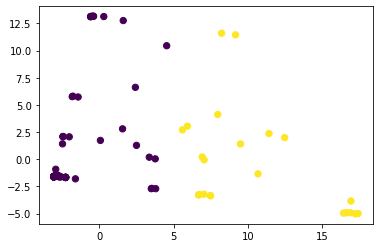

In [337]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

print(np.amax(bowMatrix))
#scale values for pca
x = RobustScaler().fit_transform(bowMatrix)
print(np.amax(x))

pca = PCA(2)
x = pca.fit_transform(x)
print(np.amax(x))
correct = False
#model doesn't make sense if control vectors are from same class so keep going until this is correct
while(not correct):
    print("gaussian iteration")
    #tied reduces the likelihood of the model overfitting a cluster
    gmm = GaussianMixture(n_components=2, covariance_type='tied',  max_iter=10).fit(x)
    labels = gmm.predict(x)
    #probability of each class (e.g. panic and non-panic)
    panic = gmm.predict_proba(x)


    
    
    print(labels[-1], labels[-2])
    #make sure control bag of words belong to different classes
    if(labels[-1] != labels[-2]):
        correct= True
        
        plt.scatter(x[:, 0], x[:, 1], c=labels, s=40, cmap='viridis')
        plt.show()

In [338]:
print(labels)

[1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


In [345]:
for country in countries_to_model:
    #sum groups classed as panicked
    country_panic_count = 0
    for i in range(5):
        country_panic_count += (labels[country_index_dict[country][i]] == labels[-2])
    print(country, country_panic_count)
print("panic classifier:", labels[-2])

USA 5
England 3
India 0
Ireland 2
Nigeria 0
South Africa 1
Scotland 2
Spain 1
Pakistan 0
Ghana 0
Brazil 1
Northern Ireland 1
Wales 0
France 0
Kenya 1
Argentina 0
Germany 1
Nederland 2
United Arab Emirates 1
Sri Lanka 0
Uganda 0
Indonesia 1
Türkiye 1
België 0
People's Republic of China 0
Israel 0
Jamaica 0
Chile 0
panic classifier: 1
